# Code for training the neural network to predict a geomagnetic baseline
### This code is a part of the manuscript "A novel neural network-based approach to derive a geomagnetic baseline for robust characterization of geomagnetic indices at mid-latitude" by Kieokaew et al., submitted to Space Weather. 

Author: Rungployphan Kieokaew (rkieokaew@irap.omp.eu) 

Last update: 02/10/2024

### This code is to update the initial model from "DailyQuietVariation_LSTM_Initial.ipynb". 

### To run this code, follow the steps in "instruction.txt" to set up the environment first. 

## Import necessary Python modules

In [4]:
#! pip install pandas

In [3]:
from numpy import mean
from numpy import std
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from dateutil.relativedelta import relativedelta

In [6]:
# Make sure the right Python kernel is chosen (e.g., keras-env) 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error#, r2_score
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
#from keras.utils.vis_utils import plot_model
#from keras import optimizers
# Load the TensorBoard notebook extension
%load_ext tensorboard
import tensorflow as tf
from datetime import datetime

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Fix random seeds for producible results

In [7]:
# Seed value
seed = 1

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed)

# 5. Configure a new global `tensorflow` session
from keras import backend as K

# Configure Tensorflow-keras session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session


<function keras.backend.set_session(session)>

## Settings

In [8]:
## Neural network settings
dropout_ratio = 0.2 
batch_size = 256
num_steps = 12 #Length of the sequential inputs (12 = 12 hours)

## Specify training length and validation length (in year) for walk forward training
train_length = 11
val_length = 1

## Input and output features
input_features = ['LT','SZA','DistSE','F10.7']
output_targets = ['xD','yD','zD']

## Set 'test' year 

In [9]:
test_year = 2012

## Specify paths for saving 'trained' models and results

### Paths of the initial model and scaler

In [10]:
initial_model = "Saved_models/DailyQuietVariation_LSTM_Initial/Step0_weights.best.hdf5"
scaler_file = "Scaler_" + "DailyQuietVariation_LSTM_Initial" + ".pkl"

print("This code will update the model: ", initial_model)
print("We are currently using the scaler: ", scaler_file)

This code will update the model:  Saved_models/DailyQuietVariation_LSTM_Initial/Step0_weights.best.hdf5
We are currently using the scaler:  Scaler_DailyQuietVariation_LSTM_Initial.pkl


In [11]:
folder_path = "DailyQuietVariation_LSTM_WalkForward"
model_path = "Saved_models/" + str(folder_path)
fig_path = "Plots/" + str(folder_path)
data_path = "Saved_data/" + str(folder_path)

## Create paths if not exist
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

if not os.path.exists(data_path):
    os.makedirs(data_path)

print("Data will be saved under ", data_path)
print("Plots will be saved to ", fig_path) 

Data will be saved under  Saved_data/DailyQuietVariation_LSTM_WalkForward
Plots will be saved to  Plots/DailyQuietVariation_LSTM_WalkForward


## Neural network model

In [12]:
model = tf.keras.models.load_model(initial_model)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, None, 100)         42000     
                                                                 
 lstm_5 (LSTM)               (None, None, 50)          30200     
                                                                 
 lstm_6 (LSTM)               (None, None, 50)          20200     
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 153       
                                                                 
Total params: 112,753
Trainable params: 112,753
Non-tr

### Train, validation, and test intervals

In [13]:
## Beginning of the dataset 
t1 = datetime(1991,1,4,0,0,0)

## The test year: the model will be updated up until the test year
t_test_begin = datetime(test_year,1,1,0,0,0) - relativedelta(hours=num_steps)
t_test_end = datetime(test_year,12,31,23,0,0)
print("Last test interval: ", t_test_begin, t_test_end)

## All train interval including the walk forward intervals 
t_train_begin = t1 
t_train_end = t_test_end - relativedelta(hours=num_steps)  #datetime(2011,12,31,23,0,0)
print("All train interval including the walk forward intervals: ", t_train_begin, t_train_end)

## Global interval - all the data will be inside this range
t1 = t1
t2 = datetime(test_year,12,31,23,0,0)
print("Global interval:", t1, t2)

Last test interval:  2011-12-31 12:00:00 2012-12-31 23:00:00
All train interval including the walk forward intervals:  1991-01-04 00:00:00 2012-12-31 11:00:00
Global interval: 1991-01-04 00:00:00 2012-12-31 23:00:00


## Download data

In [14]:
## Input directory
input_dir = 'Data/'

### All data
inputfile = str(input_dir) + 'CLF_geometrical-params_F107_daily-filter_1991-2019.csv'

df = pd.read_csv(inputfile)
df['time'] = pd.to_datetime(df['time'])
df = df.set_index(['time'])
df = df.dropna()
df = df[t1:t2]

df

,LT,SZA,DistSE,F10.7,xD,yD,zD
time,,,,,,,
1991-01-04 00:00:00,0.0,154.95,0.983283,170.2,-2.388678,15.367191,2.104001
1991-01-04 01:00:00,1.0,151.85,0.983284,170.2,-5.685187,13.831463,1.437988
1991-01-04 02:00:00,2.0,144.78,0.983284,170.2,-6.717693,9.185361,1.888480
1991-01-04 03:00:00,3.0,135.73,0.983284,170.2,-3.249444,4.324179,2.762322
1991-01-04 04:00:00,4.0,125.88,0.983284,170.2,2.946862,1.197555,2.502841
...,...,...,...,...,...,...,...
2012-12-31 19:00:00,19.0,117.69,0.983296,109.8,2.680840,1.517442,1.377726
2012-12-31 20:00:00,20.0,127.73,0.983296,109.8,1.491405,2.797655,1.218615
2012-12-31 21:00:00,21.0,137.51,0.983296,109.8,0.738684,2.818212,1.068592


### Visualize original data 

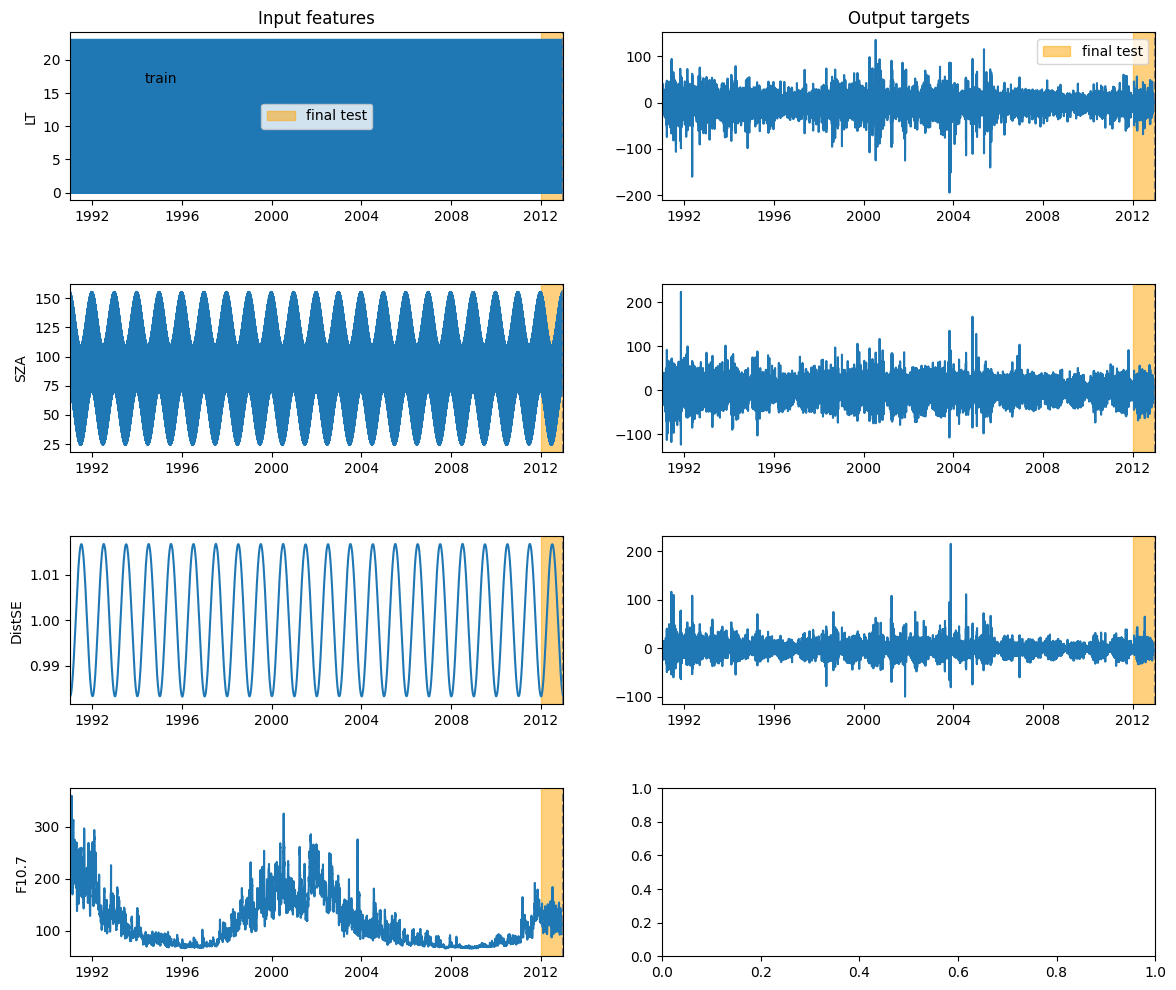

In [15]:
fig, ax = plt.subplots(len(input_features), 2, figsize=(14,12))
plt.subplots_adjust(hspace=0.5)

i = 0
for col in input_features:
    if i < len(input_features):
        ax[i,0].plot(df[col])
        ax[i,0].axvline(x=t_train_begin, ls='--', color='grey')
        ax[i,0].axvline(x=t_train_end, ls='--', color='grey')
        ax[i,0].axvspan(xmin=t_test_begin, xmax=t_test_end, color='orange', alpha=0.5, label='final test')
        ax[i,0].set_xlim(t1, t2)
        ax[i,0].set_ylabel(col)
        i += 1 

j = 0
for col in output_targets:
    if j < len(output_targets):
        ax[j,1].plot(df[col])
        ax[j,1].axvline(x=t_train_begin, ls='--', color='grey')
        ax[j,1].axvline(x=t_train_end, ls='--', color='grey')
        ax[j,1].axvspan(xmin=t_test_begin, xmax=t_test_end, color='orange', alpha=0.5, label='final test')
        ax[j,1].set_xlim(t1, t2)
        j += 1


ax[0,0].set_title('Input features')
ax[0,0].legend()
ax[0,0].text(0.15, 0.7, 'train', transform = ax[0,0].transAxes)

ax[0,1].set_title('Output targets')
ax[0,1].legend()

plt.show()

### Limit the data range to only train + test data

In [16]:
df0 = df #save the original dataframe
df = df[t_train_begin:t_test_end]
df

,LT,SZA,DistSE,F10.7,xD,yD,zD
time,,,,,,,
1991-01-04 00:00:00,0.0,154.95,0.983283,170.2,-2.388678,15.367191,2.104001
1991-01-04 01:00:00,1.0,151.85,0.983284,170.2,-5.685187,13.831463,1.437988
1991-01-04 02:00:00,2.0,144.78,0.983284,170.2,-6.717693,9.185361,1.888480
1991-01-04 03:00:00,3.0,135.73,0.983284,170.2,-3.249444,4.324179,2.762322
1991-01-04 04:00:00,4.0,125.88,0.983284,170.2,2.946862,1.197555,2.502841
...,...,...,...,...,...,...,...
2012-12-31 19:00:00,19.0,117.69,0.983296,109.8,2.680840,1.517442,1.377726
2012-12-31 20:00:00,20.0,127.73,0.983296,109.8,1.491405,2.797655,1.218615
2012-12-31 21:00:00,21.0,137.51,0.983296,109.8,0.738684,2.818212,1.068592


### Fix the new order of the columns

In [17]:
new_column_order = ['LT','SZA','DistSE','F10.7','xD','yD','zD']
df = df[new_column_order]
df

,LT,SZA,DistSE,F10.7,xD,yD,zD
time,,,,,,,
1991-01-04 00:00:00,0.0,154.95,0.983283,170.2,-2.388678,15.367191,2.104001
1991-01-04 01:00:00,1.0,151.85,0.983284,170.2,-5.685187,13.831463,1.437988
1991-01-04 02:00:00,2.0,144.78,0.983284,170.2,-6.717693,9.185361,1.888480
1991-01-04 03:00:00,3.0,135.73,0.983284,170.2,-3.249444,4.324179,2.762322
1991-01-04 04:00:00,4.0,125.88,0.983284,170.2,2.946862,1.197555,2.502841
...,...,...,...,...,...,...,...
2012-12-31 19:00:00,19.0,117.69,0.983296,109.8,2.680840,1.517442,1.377726
2012-12-31 20:00:00,20.0,127.73,0.983296,109.8,1.491405,2.797655,1.218615
2012-12-31 21:00:00,21.0,137.51,0.983296,109.8,0.738684,2.818212,1.068592


## Divide the data before scaling

In [18]:
df_train = df[t_train_begin:t_train_end]
df_train

,LT,SZA,DistSE,F10.7,xD,yD,zD
time,,,,,,,
1991-01-04 00:00:00,0.0,154.950,0.983283,170.2,-2.388678,15.367191,2.104001
1991-01-04 01:00:00,1.0,151.850,0.983284,170.2,-5.685187,13.831463,1.437988
1991-01-04 02:00:00,2.0,144.780,0.983284,170.2,-6.717693,9.185361,1.888480
1991-01-04 03:00:00,3.0,135.730,0.983284,170.2,-3.249444,4.324179,2.762322
1991-01-04 04:00:00,4.0,125.880,0.983284,170.2,2.946862,1.197555,2.502841
...,...,...,...,...,...,...,...
2012-12-31 07:00:00,7.0,96.601,0.983301,109.8,0.148385,5.484023,-0.299809
2012-12-31 08:00:00,8.0,88.145,0.983301,109.8,0.907192,7.333179,-1.357148
2012-12-31 09:00:00,9.0,80.925,0.983300,109.8,-0.042124,7.125517,-2.316762


## Scale the train data 

In [19]:
from pickle import load

# load the scaler
load_scaler = load(open(scaler_file, 'rb'))

In [20]:
## Scale the "train" data using the saved scaler
df_train_scaled = load_scaler.transform(df_train)

print('Train data: \n',df_train_scaled)
print(df_train_scaled.shape)

Train data: 
 [[0.         0.99565178 0.00180366 ... 0.53432308 0.40130096 0.47109679]
 [0.04347826 0.97200354 0.00181067 ... 0.52315435 0.39689126 0.46801321]
 [0.08695652 0.9180703  0.001818   ... 0.51965617 0.38355039 0.47009895]
 ...
 [0.39130435 0.43095478 0.00231477 ... 0.54227332 0.37763574 0.45062907]
 [0.43478261 0.38857866 0.00230123 ... 0.53616893 0.36561305 0.44793161]
 [0.47826087 0.36219944 0.00228801 ... 0.53675322 0.34458076 0.44594058]]
(192318, 7)


## Define X (independent variables) and y (dependent variables) 

In [21]:
## Get input 'X'
X_train = df_train_scaled[:,0:len(input_features)]

print('X train = \n',X_train)
print(X_train.shape)

## Get output 'y'
y_train = df_train_scaled[:,len(input_features):len(input_features)+len(output_targets)]

print('y train = \n',y_train)
print(y_train.shape)

X train = 
 [[0.         0.99565178 0.00180366 0.3560477 ]
 [0.04347826 0.97200354 0.00181067 0.3560477 ]
 [0.08695652 0.9180703  0.001818   0.3560477 ]
 ...
 [0.39130435 0.43095478 0.00231477 0.15025554]
 [0.43478261 0.38857866 0.00230123 0.15025554]
 [0.47826087 0.36219944 0.00228801 0.15025554]]
(192318, 4)
y train = 
 [[0.53432308 0.40130096 0.47109679]
 [0.52315435 0.39689126 0.46801321]
 [0.51965617 0.38355039 0.47009895]
 ...
 [0.54227332 0.37763574 0.45062907]
 [0.53616893 0.36561305 0.44793161]
 [0.53675322 0.34458076 0.44594058]]
(192318, 3)


### Transform X and y for Keras LSTM

In [22]:
def lstm_data_transform(x_data, y_data, num_steps):
    """ Changes data to the format for LSTM training """  
    X, y = list(), list()    
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps        
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break        
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequence for y
        seq_y = y_data[end_ix]        
        # Append the list with sequences
        X.append(seq_X)
        y.append(seq_y)    
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)    
    return x_array, y_array

### Transform data to the sequences for LSTM network input

In [23]:
X_train_seq, y_train_seq = lstm_data_transform(X_train, y_train, num_steps=num_steps)

print ("The new shape of X is", X_train_seq.shape)
print ("The new shape of y is", y_train_seq.shape)

The new shape of X is (192306, 12, 4)
The new shape of y is (192306, 3)


# Walk Forward

In [24]:
Year_range = pd.date_range(datetime(1991,1,1), t_test_end, freq='YS')
Year_range

DatetimeIndex(['1991-01-01', '1992-01-01', '1993-01-01', '1994-01-01',
               '1995-01-01', '1996-01-01', '1997-01-01', '1998-01-01',
               '1999-01-01', '2000-01-01', '2001-01-01', '2002-01-01',
               '2003-01-01', '2004-01-01', '2005-01-01', '2006-01-01',
               '2007-01-01', '2008-01-01', '2009-01-01', '2010-01-01',
               '2011-01-01', '2012-01-01'],
              dtype='datetime64[ns]', freq='YS-JAN')

In [25]:
df = df.reset_index()
df

,time,LT,SZA,DistSE,F10.7,xD,yD,zD
0,1991-01-04 00:00:00,0.0,154.95,0.983283,170.2,-2.388678,15.367191,2.104001
1,1991-01-04 01:00:00,1.0,151.85,0.983284,170.2,-5.685187,13.831463,1.437988
2,1991-01-04 02:00:00,2.0,144.78,0.983284,170.2,-6.717693,9.185361,1.888480
3,1991-01-04 03:00:00,3.0,135.73,0.983284,170.2,-3.249444,4.324179,2.762322
4,1991-01-04 04:00:00,4.0,125.88,0.983284,170.2,2.946862,1.197555,2.502841
...,...,...,...,...,...,...,...,...
192325,2012-12-31 19:00:00,19.0,117.69,0.983296,109.8,2.680840,1.517442,1.377726
192326,2012-12-31 20:00:00,20.0,127.73,0.983296,109.8,1.491405,2.797655,1.218615
192327,2012-12-31 21:00:00,21.0,137.51,0.983296,109.8,0.738684,2.818212,1.068592
192328,2012-12-31 22:00:00,22.0,146.34,0.983295,109.8,0.756602,2.453730,0.878923


### Find indices of the data for the train and validation data for each walk forward step 

In [26]:
split = 0
total_split = 0

begin_train_ind_list = []
end_train_ind_list = []
begin_val_ind_list = []
end_val_ind_list = []

for i in Year_range:
    #print('i = ', i)
    if i < Year_range[-num_steps]:
        print("\nStep = {}".format(split))
        
        # Train interval 
        if split == 0:
            begin_train = t_train_begin
        else:
            begin_train = i
            
        end_train = i + relativedelta(years=train_length) - relativedelta(hours=1)
        print('Train interval: ', begin_train, end_train)

        # corresponding indices 
        if split == 0:
            begin_train_ind = df[df.time == t_train_begin].index.tolist()[0]
        else:
            begin_train_ind = df[df.time == begin_train].index.tolist()[0]
            
        end_train_ind = df[df.time == end_train].index.tolist()[0]
        
        print("Corresponding indices: ", begin_train_ind, begin_train, end_train_ind, end_train)

        # Validation interval 
        begin_val = end_train + relativedelta(hours=1)
        end_val = begin_val + relativedelta(years=val_length) - relativedelta(hours=1)
        #print('begin_val: ', begin_val)
        #print('end_val: ', end_val)
        
        # corresponding indices 
        begin_val_ind = df[df.time == begin_val].index.tolist()[0]
        end_val_ind = df[df.time == end_val].index.tolist()[0]
        
        print("Validation interval: ", begin_val_ind, begin_val, end_val_ind, end_val)
        
        begin_train_ind_list.append(begin_train_ind)
        end_train_ind_list.append(end_train_ind)
        begin_val_ind_list.append(begin_val_ind)
        end_val_ind_list.append(end_val_ind)
        
        total_split += 1 
    
    else:
        pass
    split += 1

begin_test_ind = df[df.time == t_test_begin].index.tolist()[0]
end_test_ind = df[df.time == t_test_end].index.tolist()[0]

print("\nFinal test interval: ", begin_test_ind, t_test_begin, end_test_ind, t_test_end)


Step = 0
Train interval:  1991-01-04 00:00:00 2001-12-31 23:00:00
Corresponding indices:  0 1991-01-04 00:00:00 95897 2001-12-31 23:00:00
Validation interval:  95898 2002-01-01 00:00:00 104657 2002-12-31 23:00:00

Step = 1
Train interval:  1992-01-01 00:00:00 2002-12-31 23:00:00
Corresponding indices:  8688 1992-01-01 00:00:00 104657 2002-12-31 23:00:00
Validation interval:  104658 2003-01-01 00:00:00 113417 2003-12-31 23:00:00

Step = 2
Train interval:  1993-01-01 00:00:00 2003-12-31 23:00:00
Corresponding indices:  17472 1993-01-01 00:00:00 113417 2003-12-31 23:00:00
Validation interval:  113418 2004-01-01 00:00:00 122201 2004-12-31 23:00:00

Step = 3
Train interval:  1994-01-01 00:00:00 2004-12-31 23:00:00
Corresponding indices:  26232 1994-01-01 00:00:00 122201 2004-12-31 23:00:00
Validation interval:  122202 2005-01-01 00:00:00 130961 2005-12-31 23:00:00

Step = 4
Train interval:  1995-01-01 00:00:00 2005-12-31 23:00:00
Corresponding indices:  34992 1995-01-01 00:00:00 130961 200

In [27]:
df = df.set_index(['time'])

In [29]:
total_split

10

### Visualize the walk forward steps

i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9


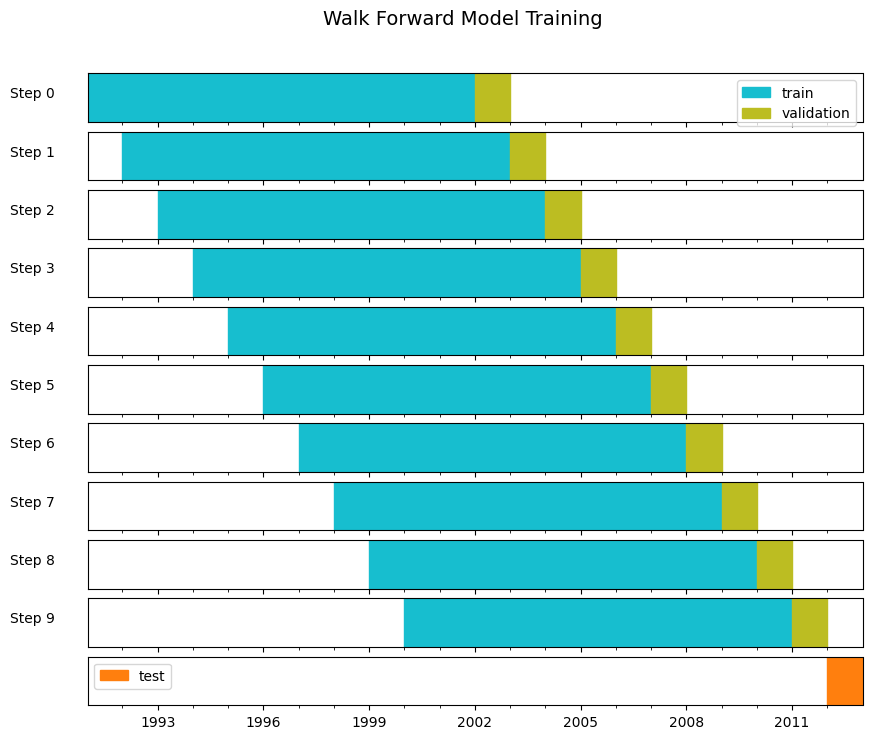

In [30]:
fig, ax = plt.subplots(total_split+1, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.2)

j = 0 

for i in range(total_split):
    print('i = ',i)
    ax[j].axvspan(ymin=0, ymax=1, xmin=df.index[begin_train_ind_list[i]], xmax=df.index[end_train_ind_list[i]], color='tab:cyan', label='train')
    ax[j].axvspan(ymin=0, ymax=1, xmin=df.index[begin_val_ind_list[i]], xmax=df.index[end_val_ind_list[i]], color='tab:olive', label='validation')
    ax[j].text(-0.1,0.5, "Step {}".format(j), transform = ax[j].transAxes)
    j = j+1
    
ax[0].legend(loc='best')

ax[total_split].axvspan(ymin=0, ymax=1, xmin=df.index[begin_test_ind], xmax=df.index[end_test_ind], color='C1', label='test')

ax[total_split].legend(loc='best')

for j in range(total_split+1):
    ax[j].set_xlim(df.index[0], df.index[-1])
    ax[j].set_ylim(0,1)
    ax[j].xaxis.set_major_locator(mdates.MonthLocator(interval=36))
    ax[j].xaxis.set_minor_locator(mdates.MonthLocator(interval=12))
    ax[j].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax[j].set_yticks([]) 
    
for k in range(total_split):
        plt.setp(ax[k].get_xticklabels(), visible=False)

fig = plt.gcf()
fig.subplots_adjust(top=0.9)
fig.suptitle("Walk Forward Model Training", fontsize=14)

plt.show()

## Train the model with the data

### Launch the Tensorboard to track the training

In [ ]:
%tensorboard --logdir logs/fit
#%tensorboard --logdir=logs/fit/ --host localhost --port 6006

## Continue the training (step 1 onwards) after obtaining the initial model

In [32]:
loss_score = []
mse_score = []

i = 1
1st Train interval:  1992-01-01 00:00:00 2002-12-31 23:00:00
1st Validation interval:  2003-01-01 00:00:00 2003-12-31 23:00:00
Epoch 1/100
374/375 [============================>.] - ETA: 0s - loss: 7.1019e-04
Epoch 1: val_loss improved from inf to 0.00131, saving model to Saved_models/DailyQuietVariation_LSTM_WalkForward/Step1_weights.best_lookback12h.hdf5
375/375 [==============================] - 25s 61ms/step - loss: 7.0998e-04 - val_loss: 0.0013
Epoch 2/100
375/375 [==============================] - ETA: 0s - loss: 7.0968e-04
Epoch 2: val_loss did not improve from 0.00131
375/375 [==============================] - 25s 67ms/step - loss: 7.0968e-04 - val_loss: 0.0013
Epoch 3/100
375/375 [==============================] - ETA: 0s - loss: 7.0794e-04
Epoch 3: val_loss improved from 0.00131 to 0.00130, saving model to Saved_models/DailyQuietVariation_LSTM_WalkForward/Step1_weights.best_lookback12h.hdf5
375/375 [==============================] - 32s 84ms/step - loss: 7.0794e-04 - va

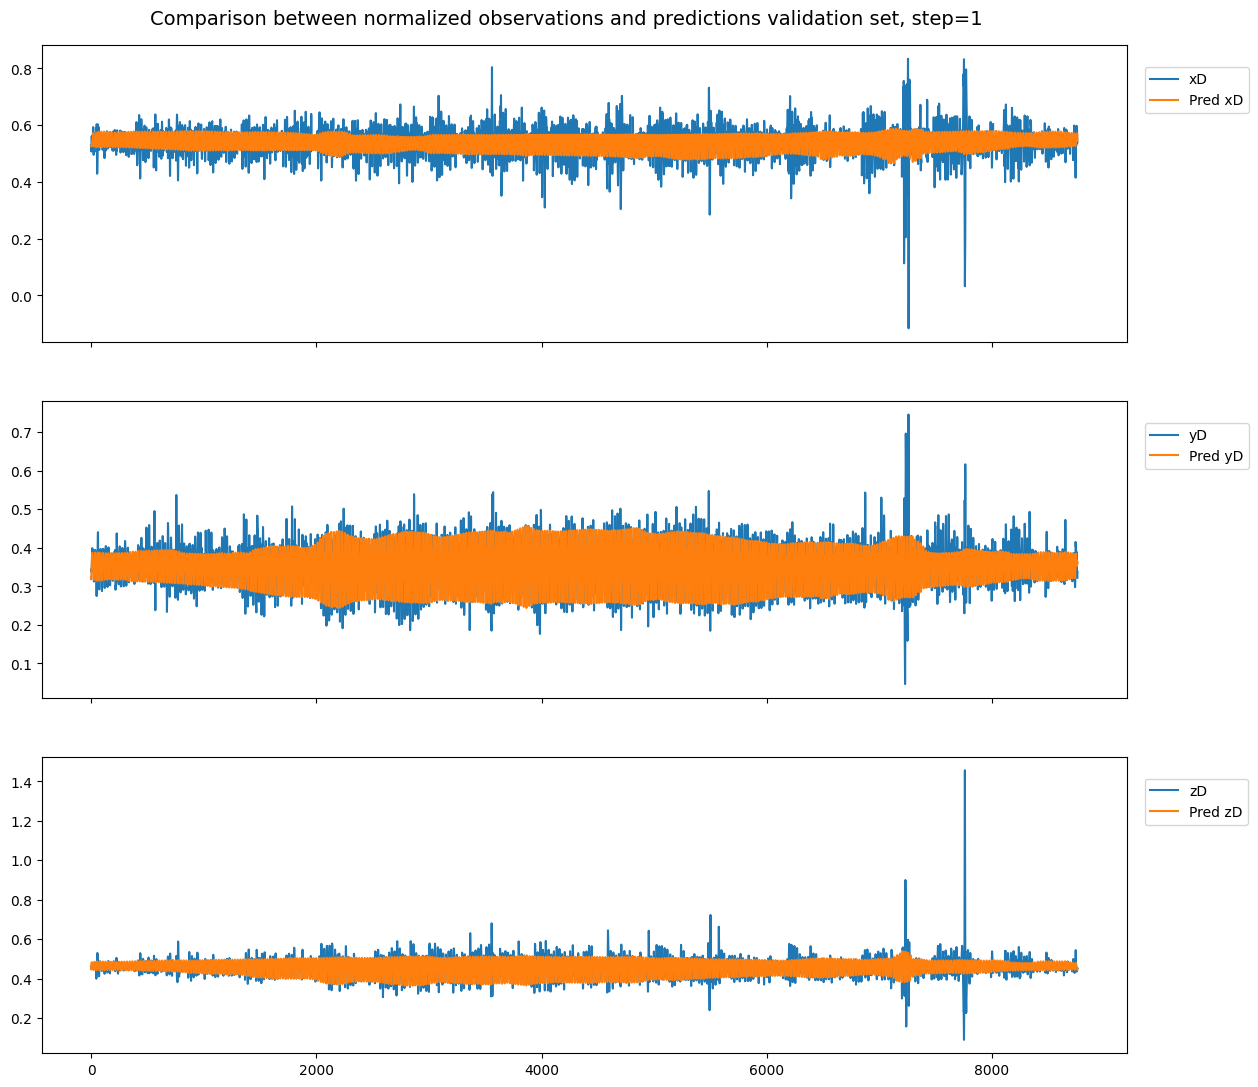

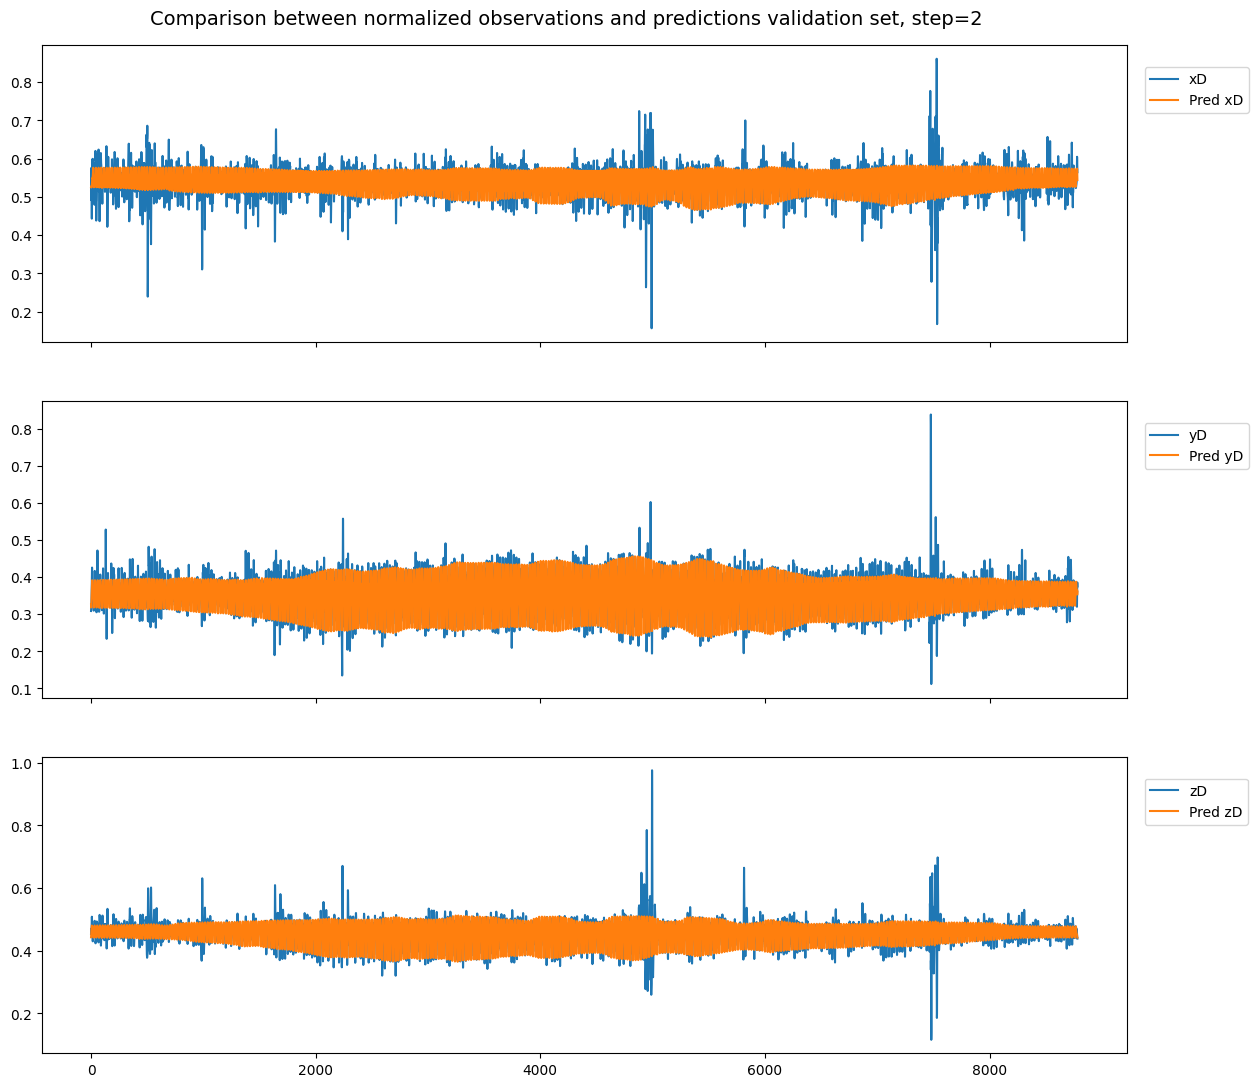

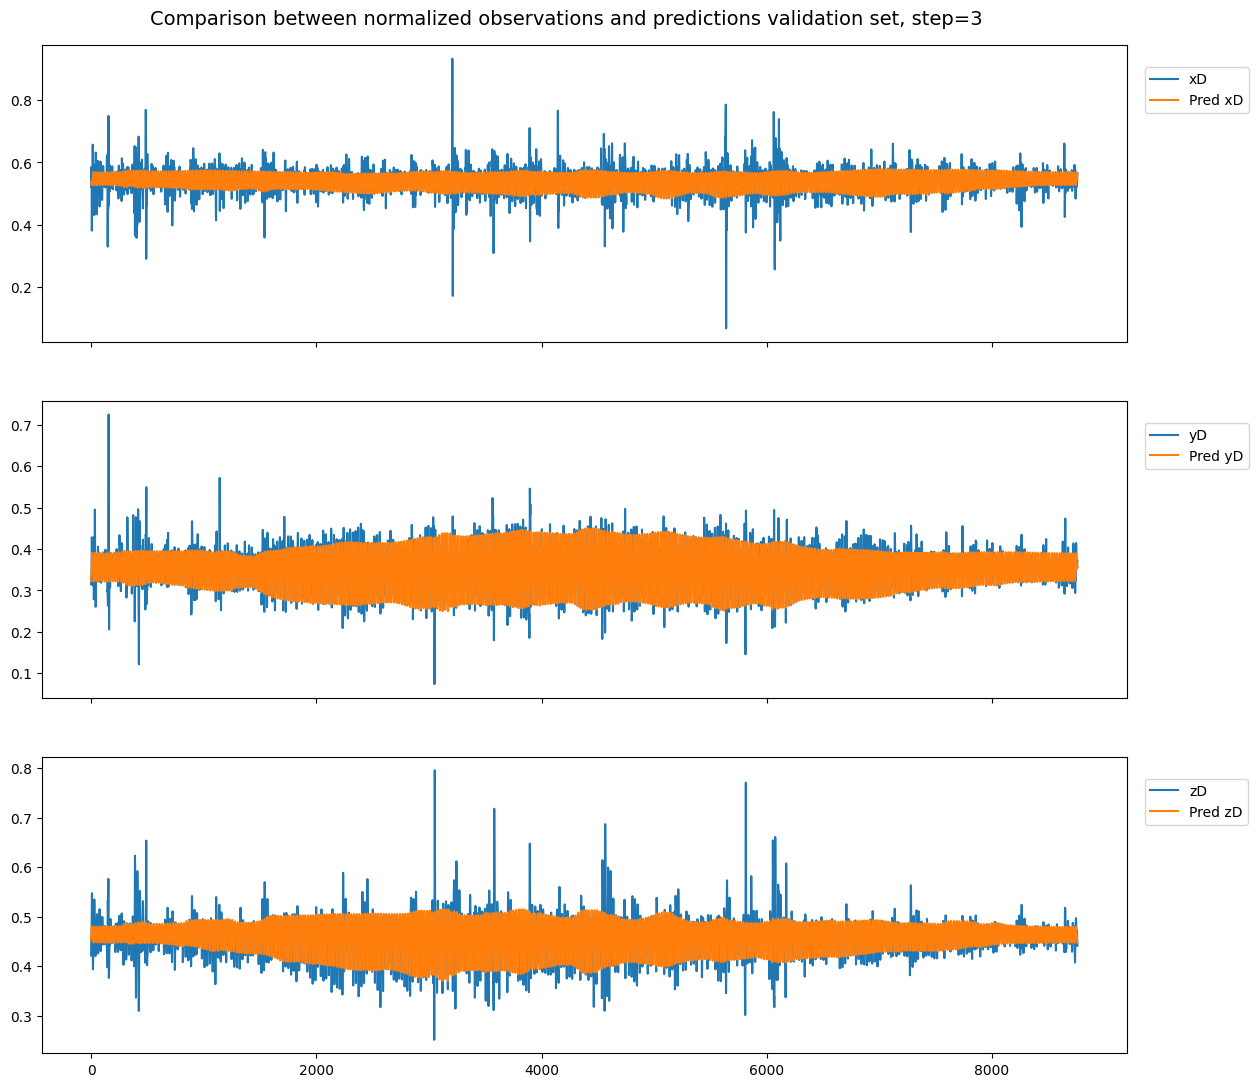

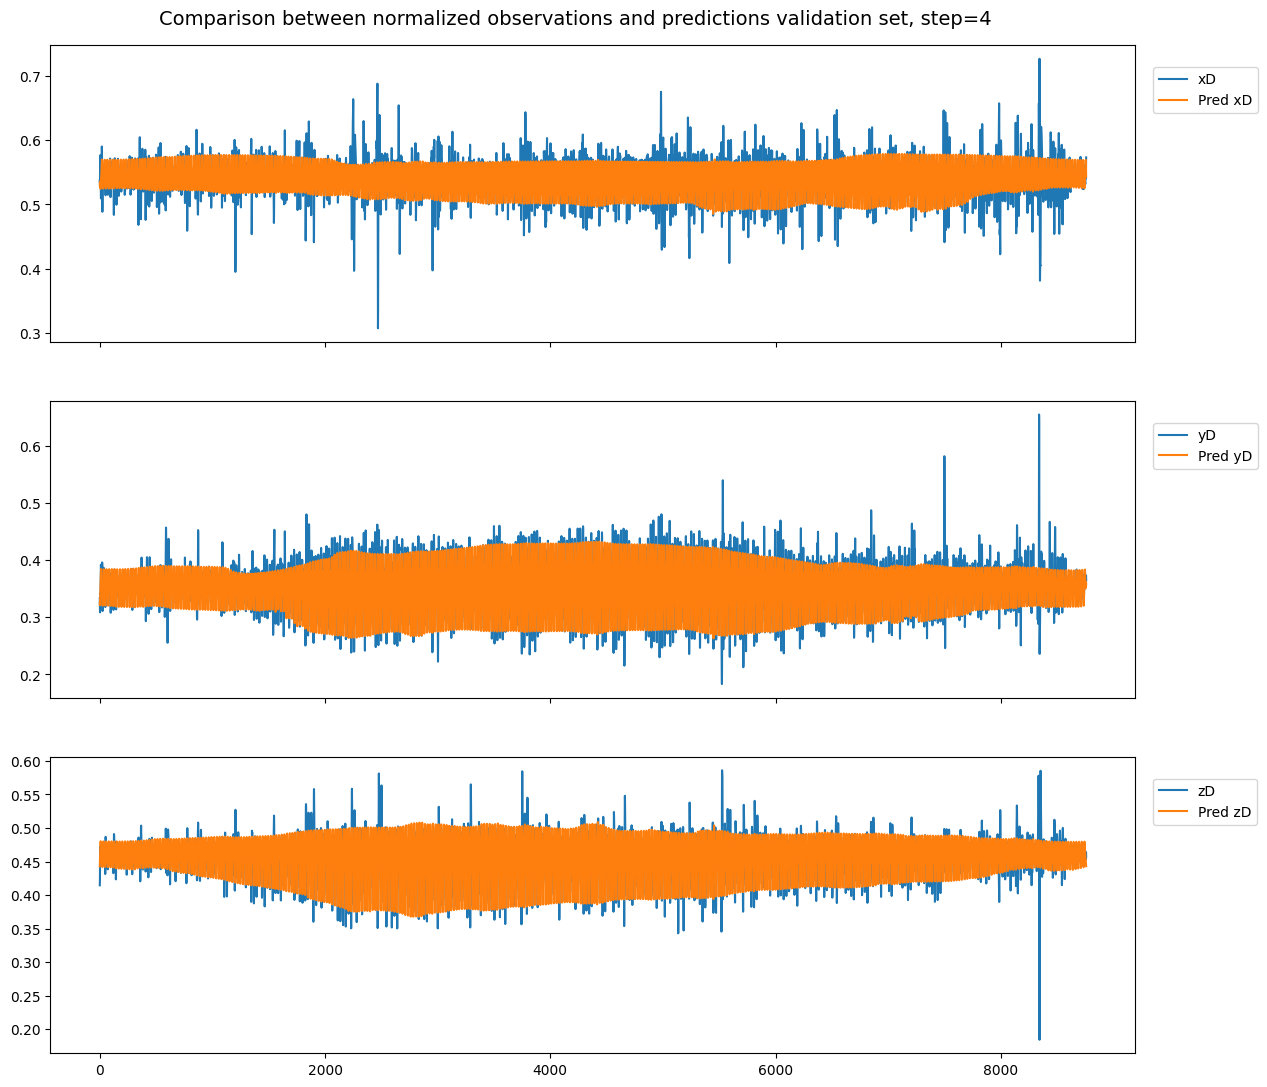

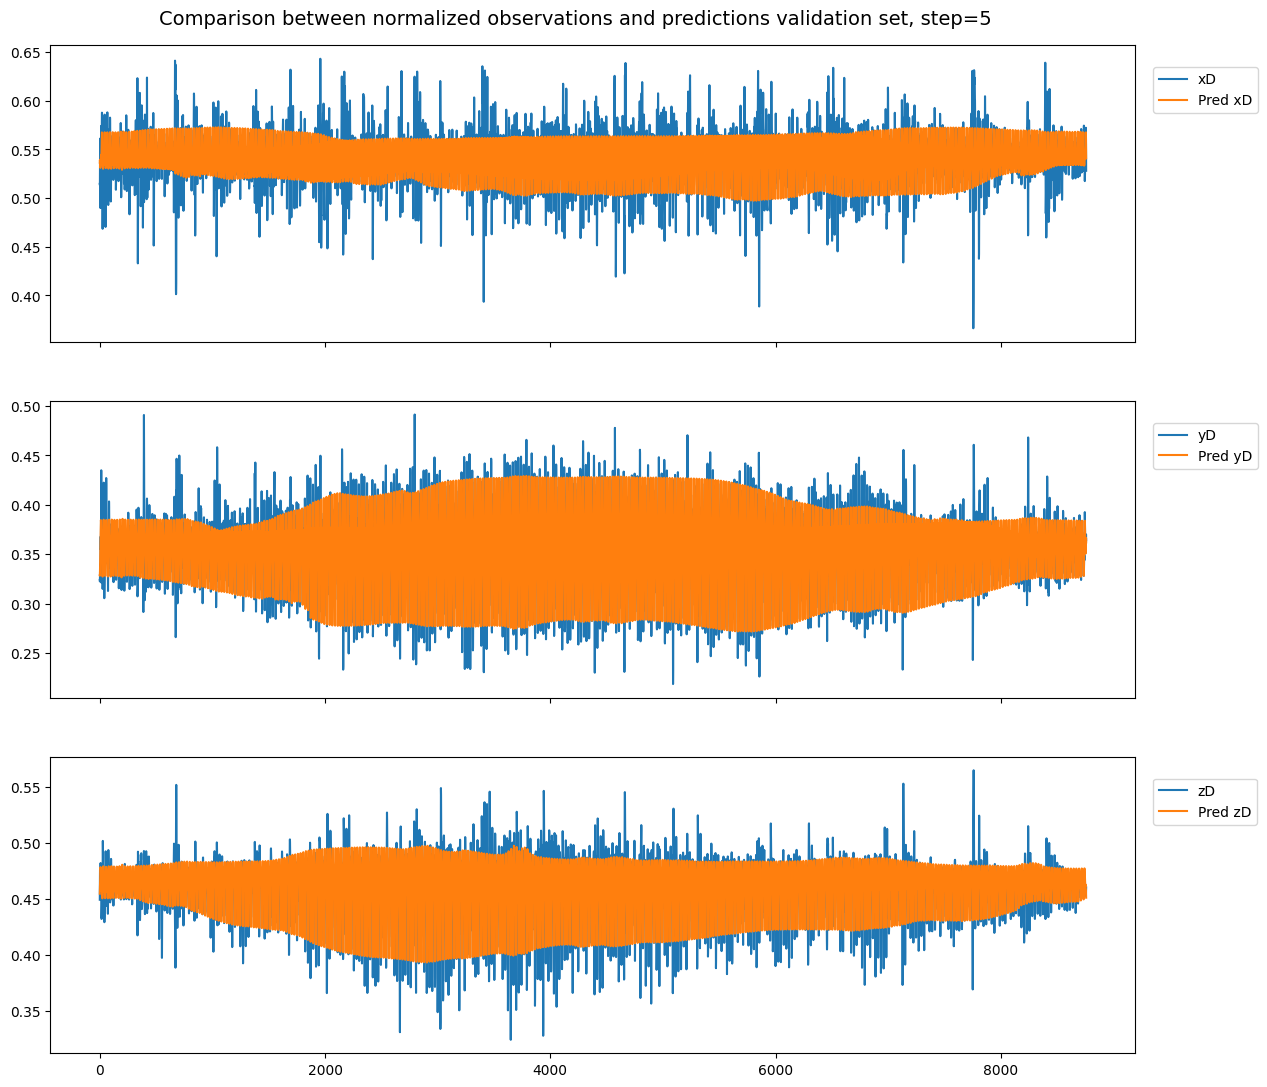

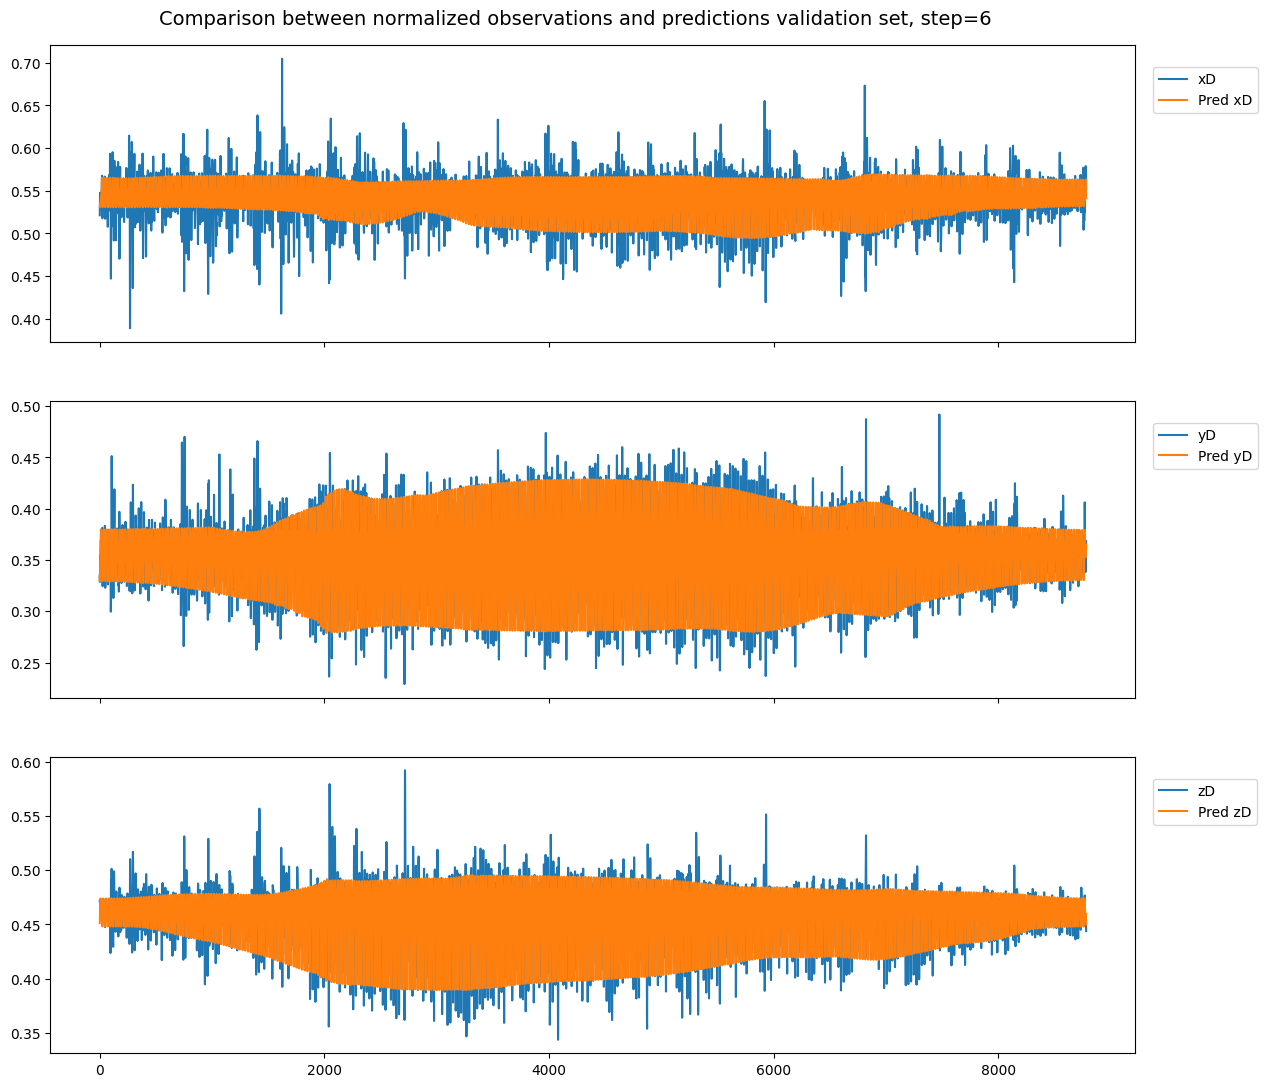

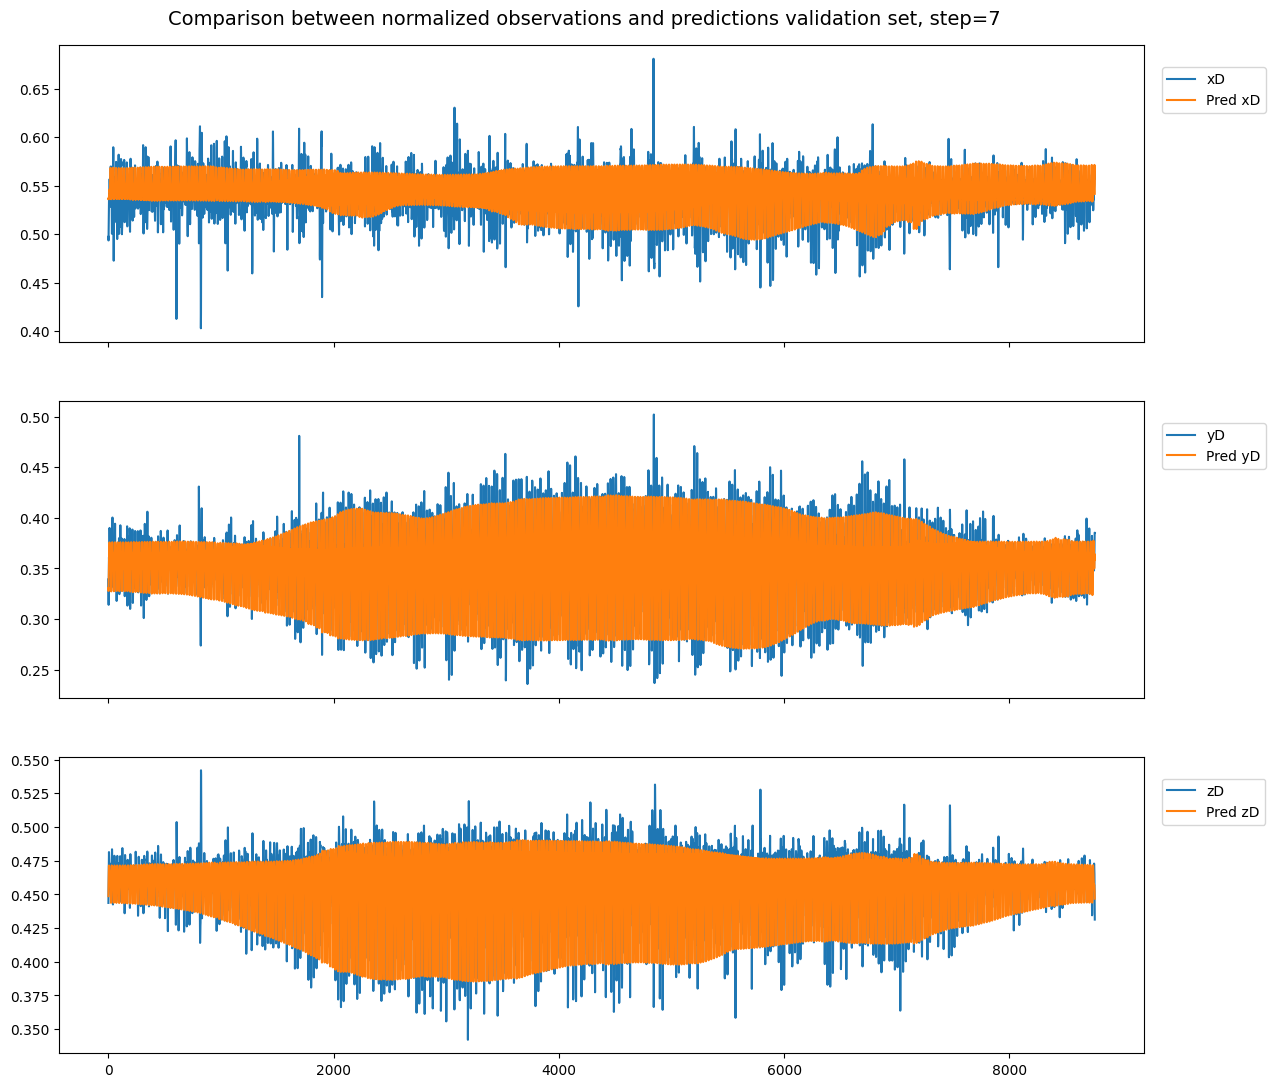

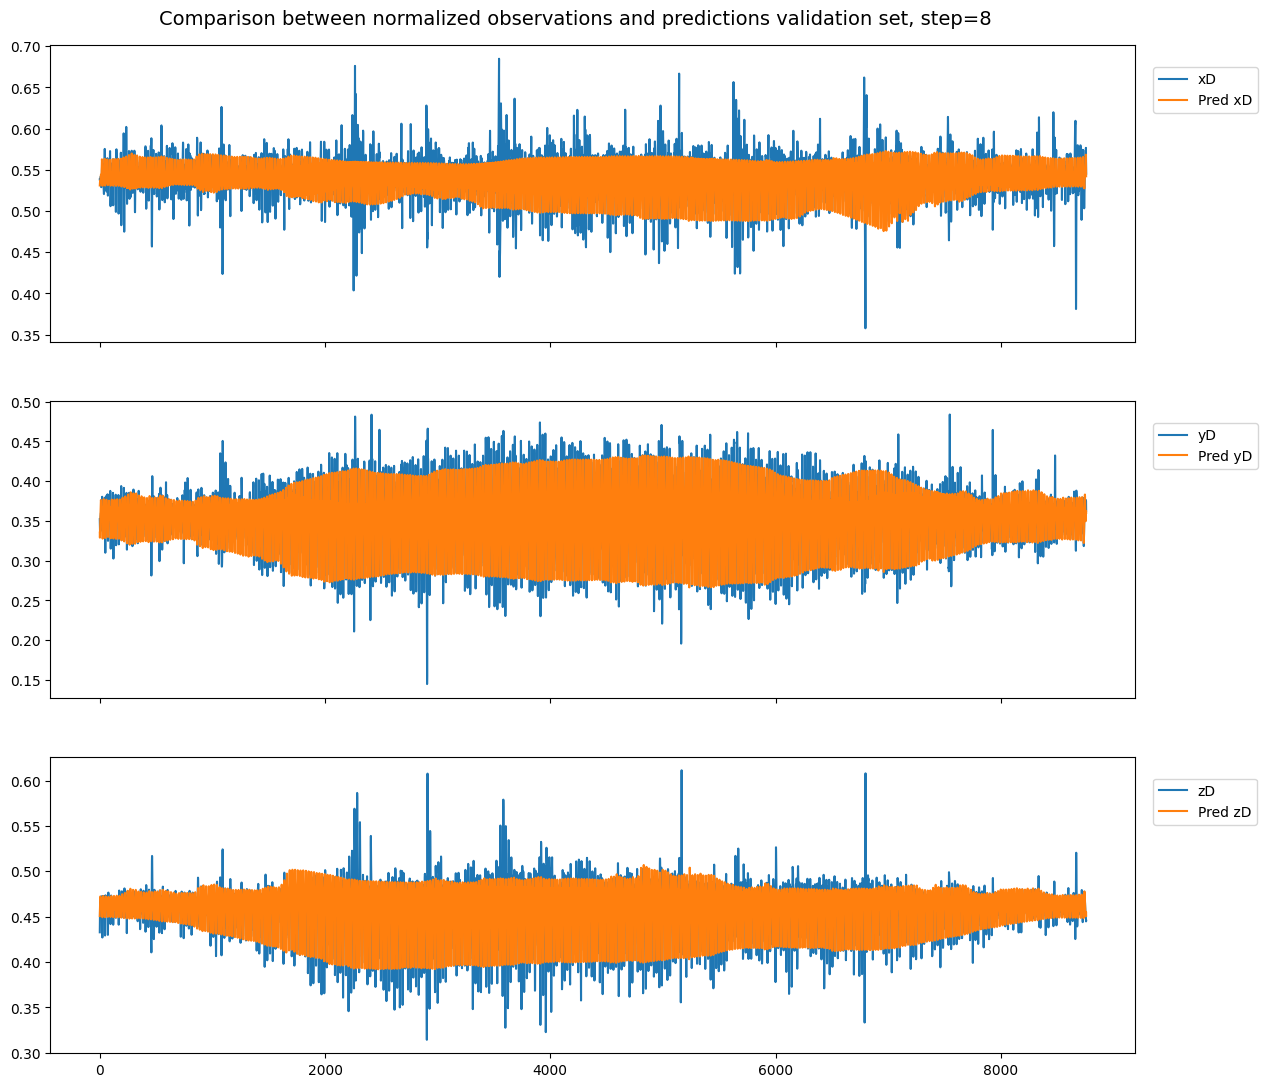

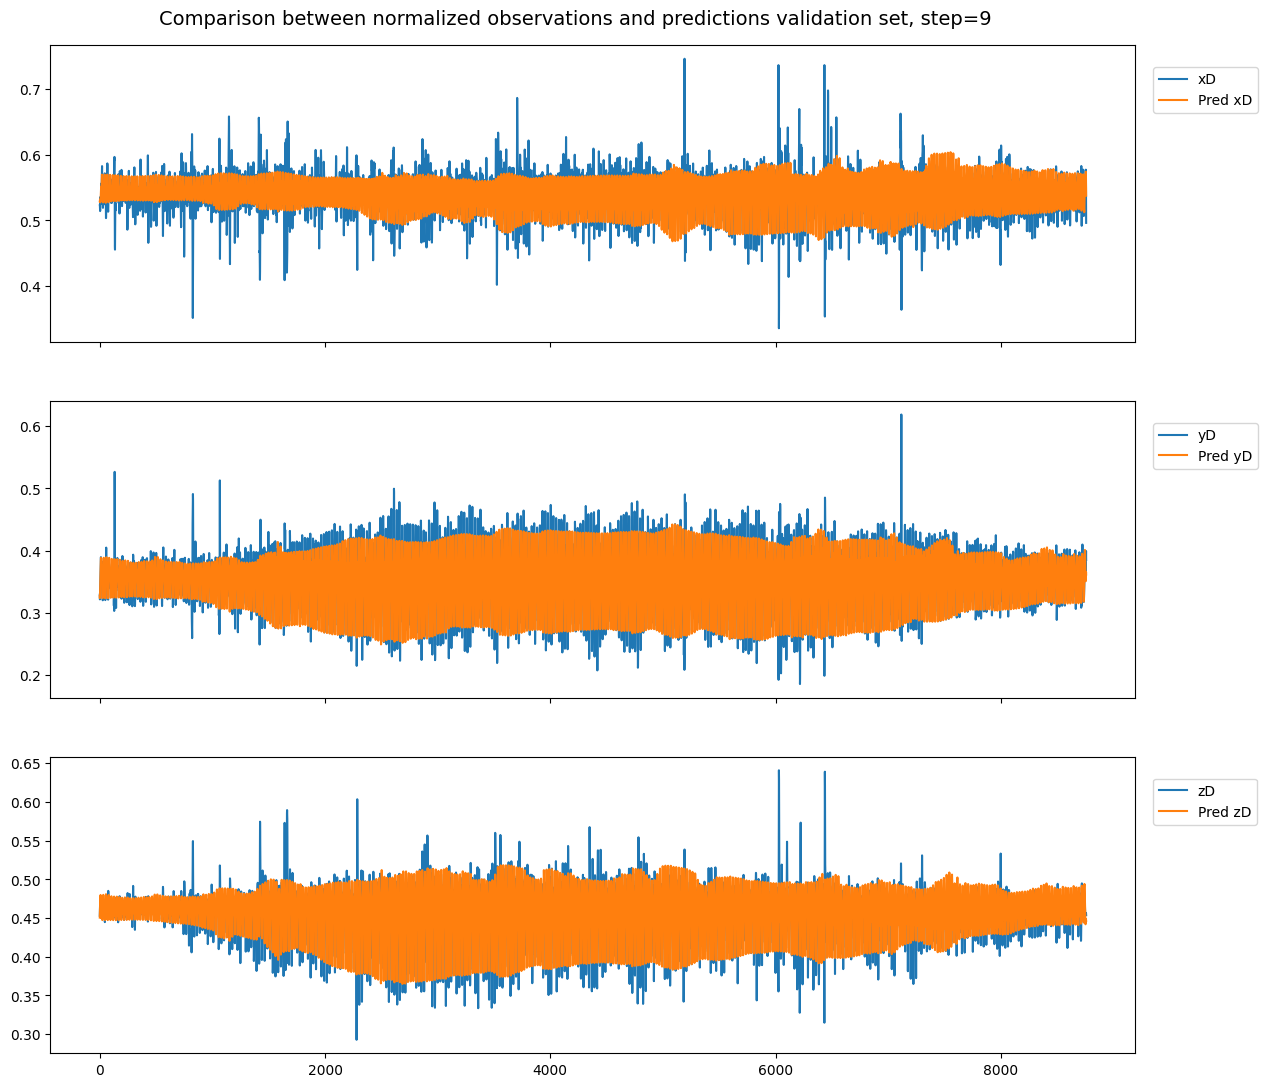

In [33]:
%%time

for i in range(1, total_split):
    print('i = {}'.format(i))
    
    X_tra = X_train_seq[begin_train_ind_list[i]:end_train_ind_list[i]]
    y_tra = y_train_seq[begin_train_ind_list[i]:end_train_ind_list[i]]

    print("1st Train interval: ",df.index[begin_train_ind_list[i]], df.index[end_train_ind_list[i]])

    X_val = X_train_seq[begin_val_ind_list[i]:end_val_ind_list[i]]
    y_val = y_train_seq[begin_val_ind_list[i]:end_val_ind_list[i]]

    print("1st Validation interval: ", df.index[begin_val_ind_list[i]], df.index[end_val_ind_list[i]])


    log_dir = "logs/fit/" + str(folder_path) + "_" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    # checkpoint
    filepath= str(model_path) + "/Step{}_weights.best_lookback12h.hdf5".format(i)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
    earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    
    
    # Load model from the previous round 
    if i == 1:
        loaded_model = tf.keras.models.load_model(initial_model)
    else:
        loaded_model = tf.keras.models.load_model(str(model_path) + "/Step{}_weights.best_lookback12h.hdf5".format(i-1))

    loaded_model.fit(X_tra, y_tra, epochs=100, 
          batch_size=batch_size,
          validation_data=(X_val, y_val), 
          callbacks=[tensorboard_callback, earlystopping_callback, checkpoint])
    
    ### Generate generalization metrics
    print('Evaluation')
    score = loaded_model.evaluate(X_val, y_val, verbose=0)
    pred = loaded_model.predict(X_val)
    mse = mean_squared_error(y_val[:,0], pred[:,0])
    
    print(f'Test loss: ', score)
    print(f'MSE of first target: ', mse)
    
    loss_score.append(score)
    mse_score.append(mse)
    
    val_predict = loaded_model.predict(X_val)
    
    fig, ax = plt.subplots(len(output_targets), 1, figsize=(14,12))
    plt.subplots_adjust(hspace=0.2)

    target_labels = output_targets

    for k in range(y_val.shape[1]):
        ax[k].plot(y_val[:,k], label=target_labels[k])
        ax[k].plot(val_predict[:,k], label='Pred {}'.format(target_labels[k]))
        ax[k].legend(loc='upper left',bbox_to_anchor=(1.01, 0.95))

    for k in range(y_val.shape[1]-1):
        plt.setp(ax[k].get_xticklabels(), visible=False)

    fig = plt.gcf()
    fig.subplots_adjust(top=0.95)
    fig.suptitle("Comparison between normalized observations and predictions validation set, step={}".format(i), fontsize=14)

    figname = str(fig_path) + "/Validation_step{}.png".format(i)
    ax = plt.gca()
    ax.figure.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0.2)
    print('Fig saved to ', figname)

## Evaluate test result 

In [34]:
df_test2 = df[t_test_begin:t_test_end]
df_test2

,LT,SZA,DistSE,F10.7,xD,yD,zD
time,,,,,,,
2011-12-31 12:00:00,12.0,70.944,0.983341,128.5,-8.790926,-9.343656,-2.543002
2011-12-31 13:00:00,13.0,72.471,0.983340,128.5,-10.514773,-13.855605,-2.342523
2011-12-31 14:00:00,14.0,76.375,0.983339,128.5,-7.225961,-13.430212,-1.888613
2011-12-31 15:00:00,15.0,82.294,0.983338,128.5,-0.500277,-10.248240,-1.124303
2011-12-31 16:00:00,16.0,89.789,0.983337,128.5,4.438202,-7.499394,0.015273
...,...,...,...,...,...,...,...
2012-12-31 19:00:00,19.0,117.690,0.983296,109.8,2.680840,1.517442,1.377726
2012-12-31 20:00:00,20.0,127.730,0.983296,109.8,1.491405,2.797655,1.218615
2012-12-31 21:00:00,21.0,137.510,0.983296,109.8,0.738684,2.818212,1.068592


### Scale the test data

In [35]:
df_test2_scaled = load_scaler.transform(df_test2)

print('Test data: \n',df_test2_scaled)
print(df_test2_scaled.shape)

Test data: 
 [[0.52173913 0.35481509 0.00353961 ... 0.51263195 0.33034599 0.4495816 ]
 [0.56521739 0.36646375 0.00350914 ... 0.50679147 0.31739033 0.4505098 ]
 [0.60869565 0.39624527 0.00347893 ... 0.51793413 0.31861181 0.45261136]
 ...
 [0.91304348 0.86261138 0.00217337 ... 0.54491874 0.3652677  0.46630294]
 [0.95652174 0.92997071 0.00216366 ... 0.54497945 0.36422112 0.46542479]
 [1.         0.98008971 0.00215426 ... 0.54450298 0.3650016  0.4645436 ]]
(8796, 7)


In [36]:
X_test2 = df_test2_scaled[:,0:len(input_features)]
y_test2 = df_test2_scaled[:,len(input_features):len(input_features)+len(output_targets)]
X_test2.shape, y_test2.shape

((8796, 4), (8796, 3))

### Reshape the test data so that we can model them using the LSTM neural network 

In [37]:
X_test2_seq, y_test2_seq = lstm_data_transform(X_test2, y_test2, num_steps=num_steps)
X_test2_seq.shape, y_test2_seq.shape

((8784, 12, 4), (8784, 3))

In [38]:
##Load the saved model 
filepath

'Saved_models/DailyQuietVariation_LSTM_WalkForward/Step9_weights.best_lookback12h.hdf5'

In [39]:
model = tf.keras.models.load_model(filepath)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, None, 100)         42000     
                                                                 
 lstm_5 (LSTM)               (None, None, 50)          30200     
                                                                 
 lstm_6 (LSTM)               (None, None, 50)          20200     
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 153       
                                                                 
Total params: 112,753
Trainable params: 112,753
Non-tr

In [40]:
test2_predict = model.predict(X_test2_seq)
print(test2_predict.shape)

275/275 [==============================] - 2s 5ms/step
(8784, 3)


### Model performance on the test data

In [41]:
print('Test: \n', df[t_test_begin:t_test_end])

score_test2 = model.evaluate(X_test2_seq, y_test2_seq, verbose=1)
print('\nLoss score = ', score_test2)

mse_test2 = []
for i in range(y_test2_seq.shape[1]):
    mse_test2.append(mean_squared_error(y_test2_seq[:,i], test2_predict[:,i]))
print('\nMSE of all targets = ', mse_test2)

Pcc_xyz_test2 = []
for i in range(y_test2_seq.shape[1]):
    Pcc_xyz_test2.append(round(np.corrcoef(y_test2_seq[:,i], test2_predict[:,i])[0,1],3))
print('\nPcc of all targets = ', Pcc_xyz_test2)

r2_xyz_test2 = []
for i in range(y_test2_seq.shape[1]):
    r2_xyz_test2.append(round(r2_score(y_test2_seq[:,i], test2_predict[:,i]),3))
print('\nr2 of all targets = ', r2_xyz_test2)


Test: 
                        LT      SZA    DistSE  F10.7         xD         yD  \
time                                                                        
2011-12-31 12:00:00  12.0   70.944  0.983341  128.5  -8.790926  -9.343656   
2011-12-31 13:00:00  13.0   72.471  0.983340  128.5 -10.514773 -13.855605   
2011-12-31 14:00:00  14.0   76.375  0.983339  128.5  -7.225961 -13.430212   
2011-12-31 15:00:00  15.0   82.294  0.983338  128.5  -0.500277 -10.248240   
2011-12-31 16:00:00  16.0   89.789  0.983337  128.5   4.438202  -7.499394   
...                   ...      ...       ...    ...        ...        ...   
2012-12-31 19:00:00  19.0  117.690  0.983296  109.8   2.680840   1.517442   
2012-12-31 20:00:00  20.0  127.730  0.983296  109.8   1.491405   2.797655   
2012-12-31 21:00:00  21.0  137.510  0.983296  109.8   0.738684   2.818212   
2012-12-31 22:00:00  22.0  146.340  0.983295  109.8   0.756602   2.453730   
2012-12-31 23:00:00  23.0  152.910  0.983295  109.8   0.615969   2.7

## Visualize model results on the test set with metrics

### Final test set

Fig saved to  Plots/Baseline_1h_normalised-results_2012.png


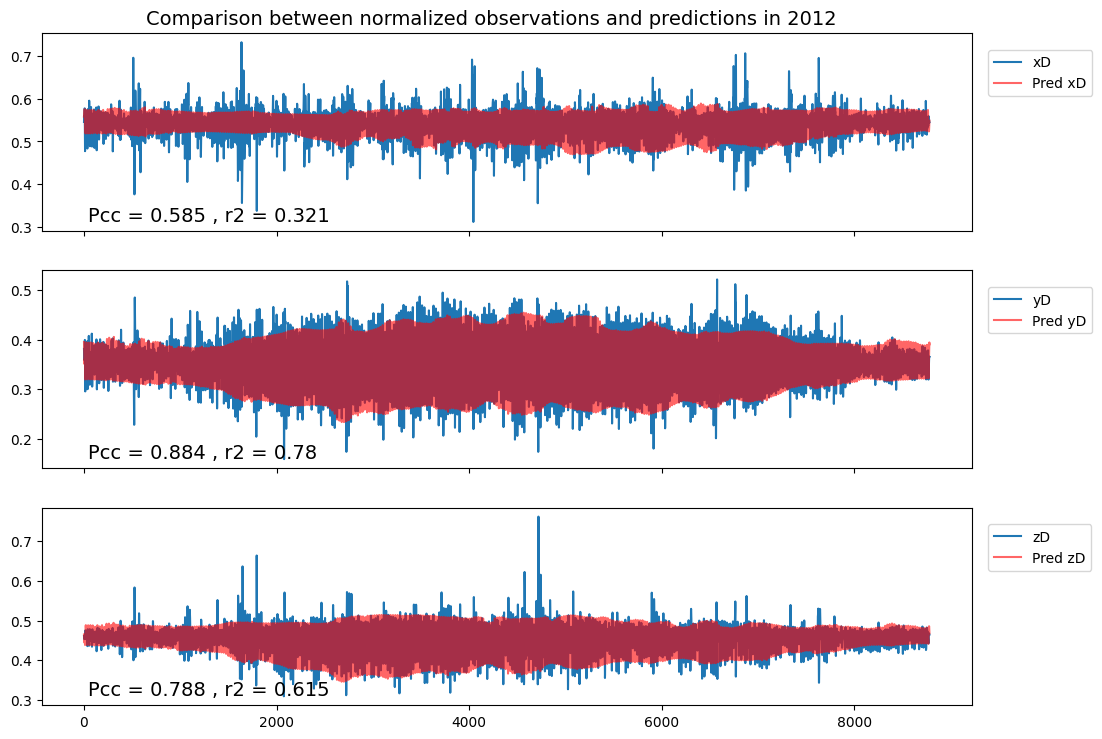

In [43]:
fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
plt.subplots_adjust(hspace=0.2)
#plt.style.use('ggplot')

target_labels = output_targets

for i in range(y_test2_seq.shape[1]):
    ax[i].plot(y_test2_seq[:,i], label=target_labels[i])
    ax[i].plot(test2_predict[:,i], label='Pred {}'.format(target_labels[i]), color='r', alpha=0.6)
    ax[i].legend(loc='upper left',bbox_to_anchor=(1.01, 0.95))
    text = str('Pcc = {}'.format(Pcc_xyz_test2[i])) + str(' , r2 = {}'.format(r2_xyz_test2[i]))
    ax[i].text(0.05, 0.05, text, fontsize=14, transform=ax[i].transAxes)
    
for i in range(y_test2_seq.shape[1]-1):
    plt.setp(ax[i].get_xticklabels(), visible=False)

fig = plt.gcf()
fig.subplots_adjust(top=0.95)
fig.suptitle("Comparison between normalized observations and predictions in {}".format(test_year), fontsize=14)

ax = plt.gca()
figname = "Plots/Baseline_1h_normalised-results_{}.png".format(test_year)  
ax.figure.set_size_inches(12, 8)  
ax.figure.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0.2)  
print('Fig saved to ', figname)

## Scale back the data

### Concatenate the scaled 'X' and the 'test predict'

In [44]:
predict2_scaled = np.concatenate((X_test2_seq[:,0,:],test2_predict), axis=1)
print(predict2_scaled.shape)
print(predict2_scaled)

(8784, 7)
[[0.52173913 0.35481509 0.00353961 ... 0.55806148 0.39486802 0.46485576]
 [0.56521739 0.36646375 0.00350914 ... 0.5587914  0.38399321 0.45720303]
 [0.60869565 0.39624527 0.00347893 ... 0.56133085 0.37123814 0.45047712]
 ...
 [0.39130435 0.43095478 0.00231477 ... 0.53789079 0.39349791 0.47923228]
 [0.43478261 0.38857866 0.00230123 ... 0.54424858 0.39407429 0.47242263]
 [0.47826087 0.36219944 0.00228801 ... 0.54817176 0.39035138 0.46780384]]


### Unscale the scaled independent (X) variables and the  modeling results (Y_modeled)

In [47]:
predict2 = load_scaler.inverse_transform(predict2_scaled)
print(predict2)
print(predict2.shape)

[[12.         70.944       0.98334149 ...  4.61783093 13.12684651
   0.75601957]
 [13.         72.471       0.98334047 ...  4.83327008  9.33957571
  -0.89687145]
 [14.         76.375       0.98333946 ...  5.58280338  4.89748438
  -2.34958077]
 ...
 [ 9.         80.925       0.98330042 ... -1.33565029 12.64969344
   3.86116288]
 [10.         75.37        0.98329997 ...  0.54088345 12.85042301
   2.39036583]
 [11.         71.912       0.98329952 ...  1.69882928 11.55388023
   1.3927659 ]]
(8784, 7)


### Create a dataframe and concatenate back the timestamps, then obtain a CSV file

In [48]:
df_predict2 = pd.DataFrame(predict2)
df_predict2.columns = new_column_order
df_predict2

,LT,SZA,DistSE,F10.7,xD,yD,zD
0,12.0,70.944,0.983341,128.5,4.617831,13.126847,0.756020
1,13.0,72.471,0.983340,128.5,4.833270,9.339576,-0.896871
2,14.0,76.375,0.983339,128.5,5.582803,4.897484,-2.349581
3,15.0,82.294,0.983338,128.5,6.548339,2.137235,-3.117145
4,16.0,89.789,0.983337,128.5,7.487133,-0.014183,-3.494837
...,...,...,...,...,...,...,...
8779,7.0,96.601,0.983301,109.8,-4.752716,4.945446,5.240878
8780,8.0,88.145,0.983301,109.8,-3.502093,9.099531,5.014304
8781,9.0,80.925,0.983300,109.8,-1.335650,12.649693,3.861163
8782,10.0,75.370,0.983300,109.8,0.540883,12.850423,2.390366


In [49]:
df_predict2['time'] = df.index[begin_test_ind+num_steps:end_test_ind+num_steps]
df_predict2 = df_predict2.set_index(['time'])
df_predict2

,LT,SZA,DistSE,F10.7,xD,yD,zD
time,,,,,,,
2012-01-01 00:00:00,12.0,70.944,0.983341,128.5,4.617831,13.126847,0.756020
2012-01-01 01:00:00,13.0,72.471,0.983340,128.5,4.833270,9.339576,-0.896871
2012-01-01 02:00:00,14.0,76.375,0.983339,128.5,5.582803,4.897484,-2.349581
2012-01-01 03:00:00,15.0,82.294,0.983338,128.5,6.548339,2.137235,-3.117145
2012-01-01 04:00:00,16.0,89.789,0.983337,128.5,7.487133,-0.014183,-3.494837
...,...,...,...,...,...,...,...
2012-12-31 19:00:00,7.0,96.601,0.983301,109.8,-4.752716,4.945446,5.240878
2012-12-31 20:00:00,8.0,88.145,0.983301,109.8,-3.502093,9.099531,5.014304
2012-12-31 21:00:00,9.0,80.925,0.983300,109.8,-1.335650,12.649693,3.861163


In [50]:
outfile2 = data_path + "/predicted{}_DailyBaseline.csv".format(test_year)
df_out2 = df_predict2[['xD','yD','zD']]
df_out2.to_csv(outfile2, sep=',', header=True)
print("Output saved as", outfile2)
print(df_out2)

Output saved as Saved_data/DailyQuietVariation_LSTM_WalkForward/predicted2012_DailyBaseline.csv
                           xD         yD        zD
time                                              
2012-01-01 00:00:00  4.617831  13.126847  0.756020
2012-01-01 01:00:00  4.833270   9.339576 -0.896871
2012-01-01 02:00:00  5.582803   4.897484 -2.349581
2012-01-01 03:00:00  6.548339   2.137235 -3.117145
2012-01-01 04:00:00  7.487133  -0.014183 -3.494837
...                       ...        ...       ...
2012-12-31 19:00:00 -4.752716   4.945446  5.240878
2012-12-31 20:00:00 -3.502093   9.099531  5.014304
2012-12-31 21:00:00 -1.335650  12.649693  3.861163
2012-12-31 22:00:00  0.540883  12.850423  2.390366
2012-12-31 23:00:00  1.698829  11.553880  1.392766

[8784 rows x 3 columns]


## Visualize rescaled prediction versus observation (final results)

In [52]:
t_plot_begin = datetime(test_year,7,1,0,0,0)
t_plot_end = datetime(test_year,7,27,0,0,0)

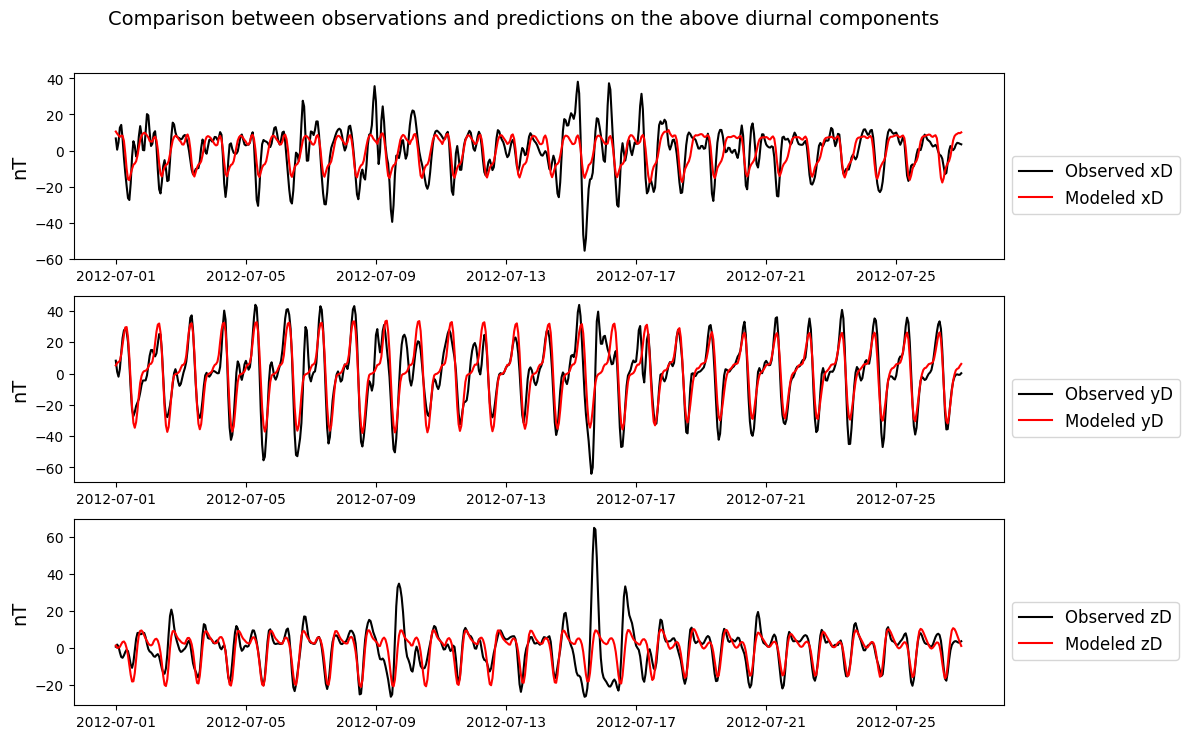

In [57]:
## test 2

output_targets = ['xD','yD','zD']

fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
plt.subplots_adjust(hspace=0.2)

j = 0
for col in output_targets:
    if j < len(output_targets):
        ax[j].plot(df0[t_plot_begin:t_plot_end][col], label='Observed ' + col, color='k')
        ax[j].plot(df_predict2[t_plot_begin:t_plot_end][col], label='Modeled ' + col, color='r')
        ax[j].legend(loc='upper left',bbox_to_anchor=(1., .6),ncols=1, fontsize=12)
        ax[j].set_ylabel('nT', fontsize=14)
        ax[j].xaxis.get_label().set_fontsize(16)
        j += 1

fig = plt.gcf()
fig.subplots_adjust(top=0.9)
fig.suptitle("Comparison between observations and predictions on the above diurnal components", fontsize=14)

plt.show()